## Fitting Sigmoid to empirical NN
### Manually selecting bin size

In [158]:
# 9 Species: AT, CE, DM, ...
# 8 Classes: ER, ERDD, GEO, GEOGD ...(each with ~500 data points)
# normalization is done on each species seperetaly.

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter

### normalization on AT,CE

In [160]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky', 'Original']
classes_pred = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky']
#data_locations = [r"/content/drive/MyDrive/random stuff/Adaptable-Sigmoids/data/AT"+c for c in classes]
data_locations = [r"/Users/lizongli/Desktop/knnResearch/Adaptable-Sigmoids/data/AT"+c for c in classes]
#data_locations_CE = [r"/content/drive/MyDrive/random stuff/Adaptable-Sigmoids/data/CE"+c for c in classes]
data_locations_CE = [r"/Users/lizongli/Desktop/knnResearch/Adaptable-Sigmoids/data/CE"+c for c in classes]
#prediction_p_value = "/content/drive/MyDrive/random stuff/Adaptable-Sigmoids/data/ATOriginal"
prediction_p_value = "Users/lizongli/Desktop/knnResearch/Adaptable-Sigmoids/data/ATOriginal"

In [161]:
# from google.colab import drive
# drive.mount('/content/drive')

In [162]:
def combine_data(data_location,classes):
    df_comb = pd.DataFrame()
    i = 0
    for protein in data_location:
        df = pd.read_csv(protein, header = None, sep = ' ')
        df['class'] = classes[i]
        df_comb = pd.concat([df, df_comb])
        i += 1
    return df_comb

In [163]:
df_comb = combine_data(data_locations,classes)
df_class = df_comb['class']
df_comb = df_comb.drop("class", axis = 1)
df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
df_comb['class'] = df_class.reset_index(drop = True)

In [164]:
# df_CE = combine_data(data_locations_CE,classes)
# df_class_CE = df_CE['class']
# df_CE = df_CE.drop("class", axis = 1)
# df_CE = pd.DataFrame(MinMaxScaler().fit_transform(df_CE))
# df_CE['class'] = df_class_CE.reset_index(drop = True)

In [165]:
# calling data(data_frame, class_name) return Species-Class empirical data as an array
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

### helper functions

In [166]:
# calculating empirical data's shortest(NN) distance 
# real data is high-dimensional data points
def data_distance(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)   # return an array of real data's NN distance


# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white',bins=100)   ## consider specifying <bins>
    ax.set_title(title)
    plt.show()
    return


# generate empirical CDF manually, satisfying:
# 1. F(x<=0) = 0
# 2. F(x_1) = 1/(n+1)
# 3. F(x_n/2) = 0.5
# 4. F(x_n) = n/(n+1)
# 5. F(x) < 1 for all x.
def empirical_CDF(data,title):
    '''
    return x,y data of CDF 
    '''    
    sort_data = np.sort(data)
    #print("data len: ",len(sort_data))
    x = np.concatenate(([0],sort_data))
    #print("x len : ",len(x))
    #print("first: ", x[0], "\nlast: ",x[-1])
    
    y = np.zeros((x.shape))
    for i in range(1,len(x)):
        y[i] = i/len(x)
    # plot_data_distance(x, "a")
    # print(plt.show())
    # print(x)
    plt.plot(x, y)
    plt.show()
    return x,y



# curve_fit()
def auto_curve_fit(data_NN, x, y, x_scale_factor, func, s, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting
    '''
    if p_control == "Gompertz":
        p0 = [1,1]
    elif p_control == "Weight":
        p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
    else:
        p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
    
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
    return popt

arctan_popt = {}

# def sigmoid_entropy(x, y, f):
#     return np.sum(y*np.log(f(x)) + (1-y)*np.log(1 - f(x)))

# plot fitted sigmoid and empirical curve in 1-y and y: i.e. y-axis = p-value and CDF
def sigmoids_for_class(data, name, factor, func_list, color_list, binning=False):
    if binning:
        x,y = binning_xy(data_binning(data))
    else:
        x,y = empirical_CDF(data, name)
    # plt.plot(x/factor, y)
    # plt.show()
    # print(y.shape)
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].scatter(x,1-y, color='b',s=10)
    # ax[0].plot(x, 1-y, color="b")
    
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)
    # ax[1].plot(x, y, color="b")
    
    print("For ",name," :")
    for i in range(len(func_list)):
        try:
            if i == 7:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Gompertz")
            elif i == 6:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Weight")
            else:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y)
        except RuntimeError:
            print("error in ",str(func_list[i])[9:-22])
            continue
        # y = y/factor
        y2 = func_list[i](x/factor, *p)
        # print(len(x/factor))
        # print(y2)
        if func_list[i] == arctan:
          arctan_popt[f"{name}"] = p

        if func_list[i] == arctan_GD:
            # y2 = func_list[i](x/factor, *p)
            # print(y2)
            # print(y)
            # error = sigmoid_entropy(x/factor, y, func_list[i])
            # plt.plot(x, y)
            # plt.plot(x/factor, (y2-y)**2)
            # plt.show()

            # print(((y2-y)**2)[-20:])
            # error = np.sum((y2[-20:] - y[-20:])**2)
            # print(str(error))
            # print("-----------")
            # error = np.sum(((1-y2) - (1-y))**2)
            error = np.log(np.sum(np.exp(2 * ((1-y2) - (1-y)))))
            print("arctan_GD: " + str(error))
            ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
            ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])

        if func_list[i] == arctan:
            # y2 = func_list[i](x/factor, *p)
            # print(y2)
            # print(((y2-y)**2)[-20:])
            # error = np.sum((y2[-20:] - y[-20:])**2)
            # print(str(error))
            # print("-----------")
            # error = np.sum(((1-y2) - (1-y))**2)
            error = np.log(np.sum(np.exp(2 * ((1-y2) - (1-y)))))
            # error = sigmoid_entropy(x/factor, y, func_list[i])
            # plt.plot(x, y)
            # plt.plot(x/factor, (y2-y)**2)
            # plt.show()
            print("Gom: " + str(error))
            ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
            ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
        y2-y
        (1-y2)-(1-y)
        1-y2-1+y 
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()

### Sigmoid functions

In [167]:
# 4.11 Adjust range to (0,1)

def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))      
    return m

def tanh(x, x0, k): 
    m = (1+np.tanh(k*(x-x0)))/2
    return m

def arctan(x, x0, k):
    m = (1+(2/np.pi)*np.arctan(k*(x-x0)))/2
    return m

def GD(x, x0, k):
    m = (1+(4/np.pi)*np.arctan(np.tanh(k*(x-x0))))/2
    return m

def ERF(x, x0, k):
    m = (1+erf(k*(x-x0)))/2
    return m

def algebra(x, x0, k):
    m = (1+x/((1+abs(x)**k)**(1/k)))/2
    return m

def arctan_GD(x,x0,k, w):
    # print(x)
    # print(x0)
    # print(k)
    # print(w)
    m = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)
    return m

def Gompertz(x,b,c):
    m = np.e**(-np.e**(b-c*x))
    return m

### Fitting on All points without binning

In [168]:

factors = [1e-5,  1e-2,   1e-4,   1e-3,   1e-2,  1e-4, 1e-2,   1e-3]
# factors = [1,1,1,1,1,1,1,1]
colors = ['g','r','c','m','y','k','brown','gray']
functions = [logistic, tanh, arctan, GD, ERF, algebra, arctan_GD, Gompertz]

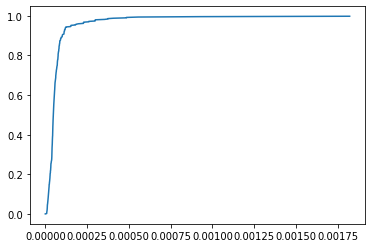

For  ER  :
curve_fit parameter on  logis:  [0.74609738 4.29314045]
curve_fit parameter on  t:  [0.74609741 2.14656991]
curve_fit parameter on  arc:  [0.73438878 4.44390805]
Gom: 6.188206253431799
curve_fit parameter on :  [0.74436816 1.75538436]
curve_fit parameter on  :  [0.74823162 1.81804087]
curve_fit parameter on  alge:  [0.7063388  0.42247565]
curve_fit parameter on  arctan:  [0.74033187 2.25764551 0.68600891]
arctan_GD: 6.190974923148689
curve_fit parameter on  Gompe:  [1.75786274 2.90931778]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


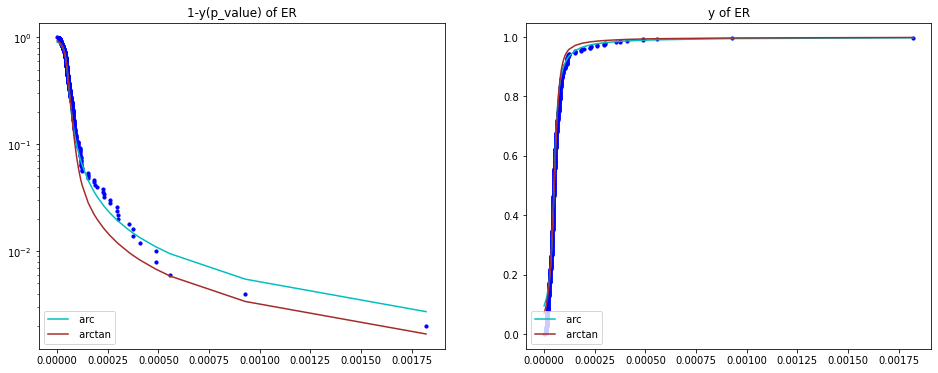

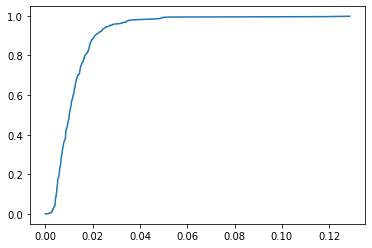

For  ERDD  :
curve_fit parameter on  logis:  [0.85422946 3.37587043]
curve_fit parameter on  t:  [0.85422959 1.68793284]
curve_fit parameter on  arc:  [0.84002395 3.33586695]
Gom: 6.196012031787625
curve_fit parameter on :  [0.85190945 1.37126769]
curve_fit parameter on  :  [0.85758766 1.44066784]
curve_fit parameter on  alge:  [0.81624829 0.39290878]
curve_fit parameter on  arctan:  [0.85006999 1.47278541 0.90005227]
arctan_GD: 6.19401083420843
curve_fit parameter on  Gompe:  [1.58329433 2.35712784]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


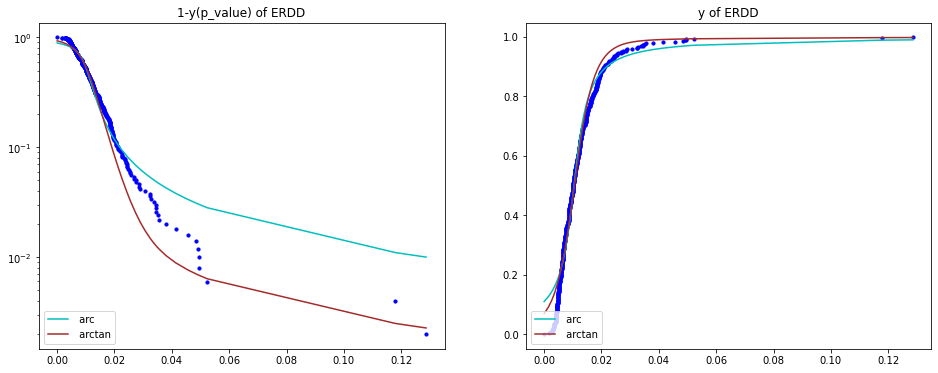

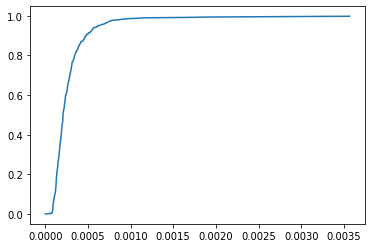

For  GEO  :
curve_fit parameter on  logis:  [0.81391309 3.98403236]
curve_fit parameter on  t:  [0.81391317 1.99201607]
curve_fit parameter on  arc:  [0.79797621 3.93001527]
Gom: 6.18437656888813
curve_fit parameter on :  [0.81174147 1.61430741]
curve_fit parameter on  :  [0.81670624 1.70671086]
curve_fit parameter on  alge:  [0.75766946 0.38141551]
curve_fit parameter on  arctan:  [ 0.80976294  8.85553716 -0.94404642]
arctan_GD: 6.191555828180047
curve_fit parameter on  Gompe:  [1.83358249 2.77189869]


/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_88895/1069753868.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_88895/1069753868.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


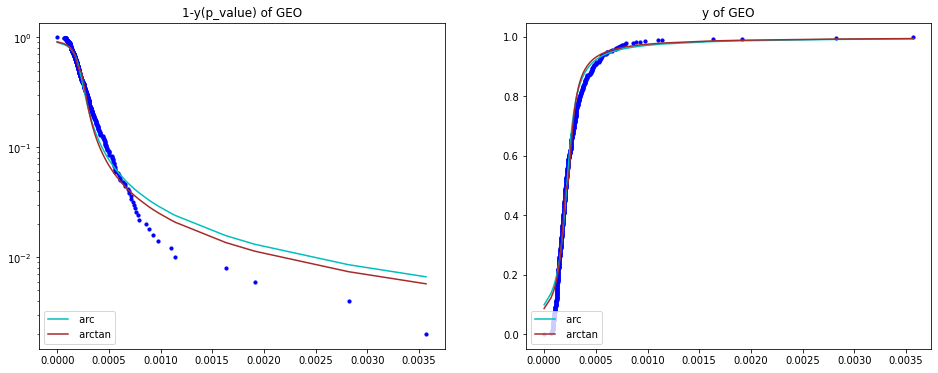

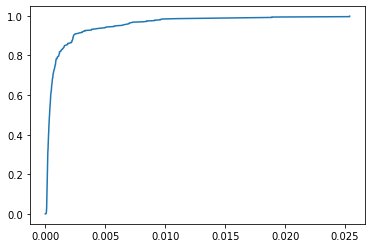

For  GEOGD  :
curve_fit parameter on  logis:  [0.3548311  5.63089266]
curve_fit parameter on  t:  [0.35483182 2.81543186]
curve_fit parameter on  arc:  [0.33998243 5.3686164 ]
Gom: 6.16121290868228
curve_fit parameter on :  [0.35290241 2.26749326]
curve_fit parameter on  :  [0.3574192  2.42648315]
curve_fit parameter on  alge:  [0.30217549 0.78112375]
curve_fit parameter on  arctan:  [ 0.35135358 13.44138922 -1.11345767]
arctan_GD: 6.170492856290384
curve_fit parameter on  Gompe:  [0.99437121 3.98181538]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


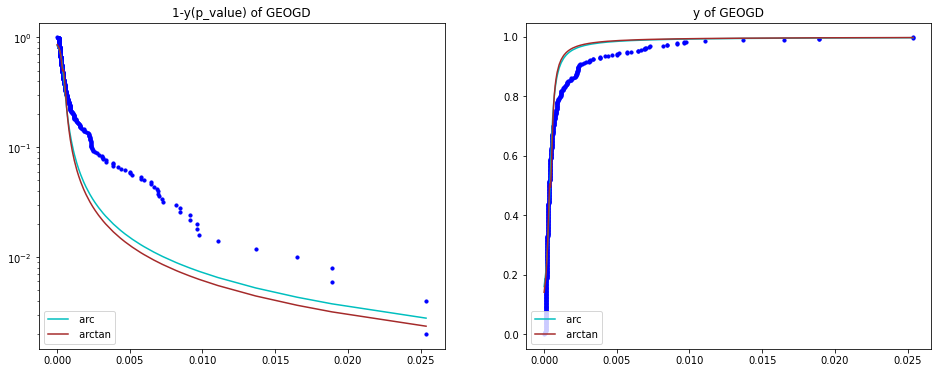

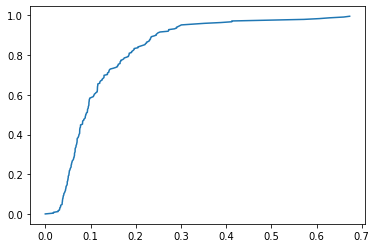

For  HGG  :
curve_fit parameter on  logis:  [0.78789559 3.22939405]
curve_fit parameter on  t:  [0.78789511 1.61470027]
curve_fit parameter on  arc:  [0.75761668 3.27552012]
Gom: 5.490868757951828
curve_fit parameter on :  [0.78346421 1.31237476]
curve_fit parameter on  :  [0.79416174 1.37452484]
curve_fit parameter on  alge:  [0.71565964 0.42324306]
curve_fit parameter on  arctan:  [ 0.77638831  8.26725314 -1.1282138 ]
arctan_GD: 5.498897096977765
curve_fit parameter on  Gompe:  [1.38823968 2.29767846]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


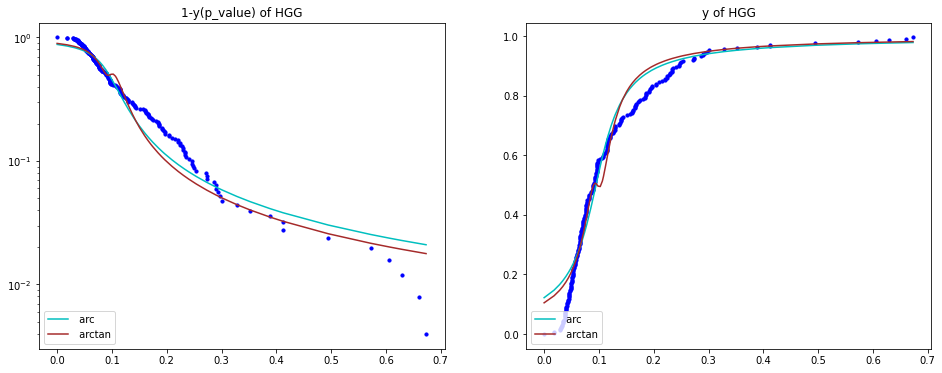

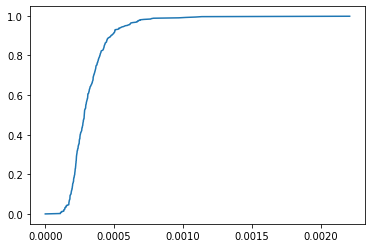

For  SF  :
curve_fit parameter on  logis:  [0.91883645 4.90069174]
curve_fit parameter on  t:  [0.91883648 2.45034608]
curve_fit parameter on  arc:  [0.90816128 4.84965765]
Gom: 6.1940166865693405
curve_fit parameter on :  [0.91721502 1.99006756]
curve_fit parameter on  :  [0.92098551 2.09301509]
curve_fit parameter on  alge:  [0.89158424 0.31270279]
curve_fit parameter on  arctan:  [0.91686834 2.02950445 0.97190028]
arctan_GD: 6.193260973055798
curve_fit parameter on  Gompe:  [2.72942177 3.43764009]


/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_88895/1069753868.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_88895/1069753868.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


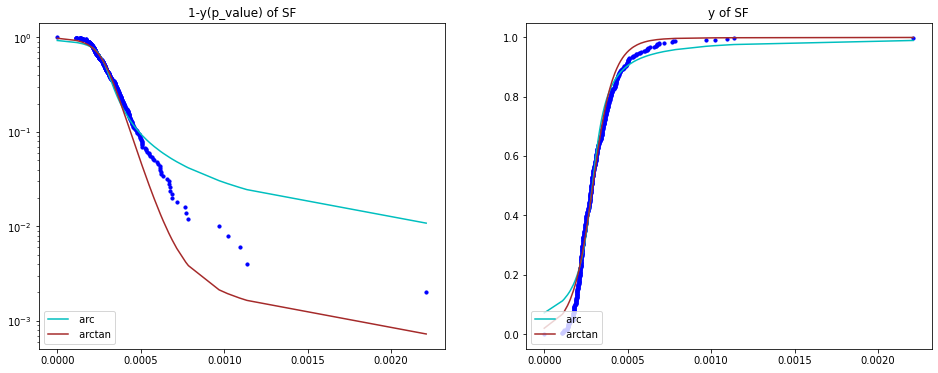

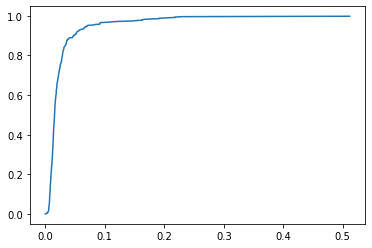

For  SFDD  :
curve_fit parameter on  logis:  [0.65634747 4.49207278]
curve_fit parameter on  t:  [0.65634749 2.24603623]
curve_fit parameter on  arc:  [0.63733876 4.52980293]
Gom: 6.173222580316282
curve_fit parameter on :  [0.65343424 1.82757353]
curve_fit parameter on  :  [0.66035964 1.91079461]
curve_fit parameter on  alge:  [0.60853718 0.44604358]
curve_fit parameter on  arctan:  [0.64091487 3.03302273 0.39888764]
arctan_GD: 6.174879996887764
curve_fit parameter on  Gompe:  [1.64090678 3.13348569]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


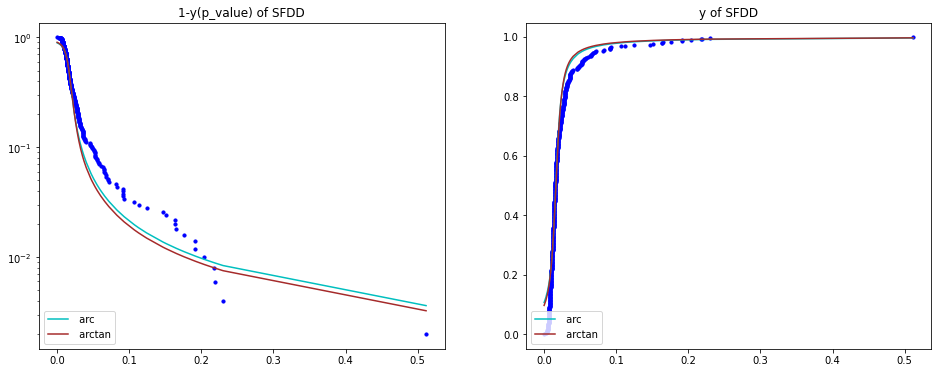

In [169]:
# AT
for i in range(len(classes_pred[:-1])):
    data_i = data_distance(data(df_comb,classes_pred[:-1][i]))
    sigmoids_for_class(data_i, classes_pred[:-1][i], np.mean(data_i), functions, colors)

In [170]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_CE,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], np.mean(data_i), functions, colors)

NameError: name 'df_CE' is not defined

### Binning

In [ ]:
# binning first, add (0,0) at the front later when calculate y
#make it smooth

def data_binning(data):
    
    x = np.sort(data) 
    N = len(x)                   # e.g N = 500, sqrt(500)=22.3
    lower = int(np.floor(np.sqrt(N))) # 22
    upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
    
    if lower*upper >= N:
        small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
        small_bin_size = int(lower - 1)  # 21
        large_bin_size = lower
    else: # HGG -> sqrt(252) = 15.8
        small_bin_num = int(upper**2 - N) # 16*16-252 =4
        small_bin_size = lower  # 15
        large_bin_size = upper
    
    large_bin_num = int(upper - small_bin_num) # 23-6 = 17

    # small_bin_size*small_bin_num + lower*large_bin_num = N

    bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
    print("items in each bin: ", bin_count)
    binned_data = []
    i = 0
    for count in bin_count:
        binned_data.append(np.mean(x[i:i+count]))
        i += count
    
    return binned_data


def binning_xy(binned_data):
    x = np.concatenate(([0],binned_data))
    y = np.zeros((x.shape))
    
    for i in range(1,len(x)):
        y[i] = i/len(x)
        
    return x,y
 

#### AT

In [ ]:
# for i in range(len(classes[:-1])):
#     data_i = data_distance(data(df_comb,classes[:-1][i]))
#     sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

#### CE

In [ ]:
# for i in range(len(classes[:-1])):
#     data_i = data_distance(data(df_CE,classes[:-1][i]))
#     sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

In [ ]:
# arctan_popt

In [ ]:
def euclid(origin, other):
  return np.sum((origin - other) ** 2)**(1/2)

def NN_distance(ref_point, data):
  nearest_distance = 1e999
  for point in data:
    if euclid(ref_point, point) < nearest_distance: 
      nearest_distance = euclid(ref_point, point)
  return nearest_distance

# NN_dict = {}

In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in arctan_popt:
  nearest_distance = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
  #print(*arctan_popt[f'{target}'])
  #print(nearest_distance)
  # NN_dict["arctan_GD"] = nearest_distance
  #print("--")
  print(arctan_GD(nearest_distance,*arctan_popt[f'{target}']))
  #least square fittinhg, make it as a library, can only have dataset with numbers, no images
  #different variables, weigh in a approtate place
  #create a library, then find a new data never see before, test it 
  #uci ml repository

1.9852769575540405
--
0.9664408249707113
1.9793861088833817
--
0.9718401609077627
1.9870075579958681
--
0.9816160770959803
1.9396195679649006
--
0.9426719231381333
1.9464248641202093
--
0.9409854586707858
1.950389841772879
--
0.9748968260379774
0.8595825841791674
--
0.7602980007563807
1.6492102611032413
--
0.9831163142312822


In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in arctan_popt:
  nearest_distance = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
  print(ERF(nearest_distance,*arctan_popt[f'{target}']))

TypeError: ERF() takes 3 positional arguments but 4 were given